# Why GPflux is a modern (deep) GP library

In this notebook we go over some of the features that make GPflux a powerful, deep-learning-style GP library. We demonstrate the out-of-the-box support for monitoring during the course of optimisation, adapting the learning rate, and saving & serving (deep) GP models.

## Setting up the dataset and model

### Motorcycle: a toy one-dimensional dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

tf.get_logger().setLevel("INFO")

2023-05-31 07:11:09.550188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Text(0, 0.5, 'Acceleration')

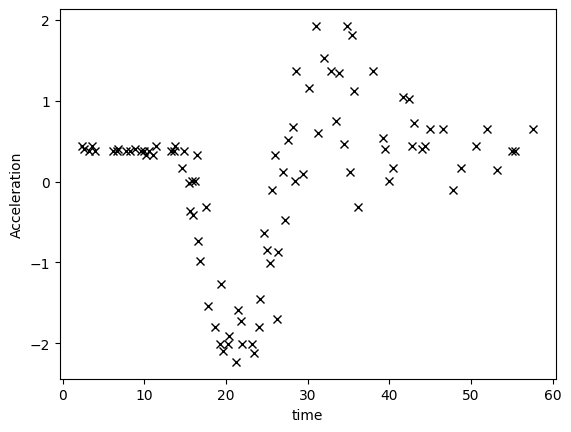

In [2]:
def motorcycle_data():
    """
    The motorcycle dataset where the targets are normalised to zero mean and unit variance.
    Returns a tuple of input features with shape [N, 1] and corresponding targets with shape [N, 1].
    """
    df = pd.read_csv("./data/motor.csv", index_col=0)
    X, Y = df["times"].values.reshape(-1, 1), df["accel"].values.reshape(-1, 1)
    Y = (Y - Y.mean()) / Y.std()
    return X, Y


X, Y = motorcycle_data()
plt.plot(X, Y, "kx")
plt.xlabel("time")
plt.ylabel("Acceleration")

### Two-layer deep GP

To keep this notebook focussed we are going to use a predefined deep GP architecture `gpflux.architectures.build_constant_input_dim_deep_gp` for creating our simple two-layer model.

In [3]:
import gpflux

from gpflux.architectures import Config, build_constant_input_dim_deep_gp
from gpflux.models import DeepGP

config = Config(
    num_inducing=25, inner_layer_qsqrt_factor=1e-5, likelihood_noise_variance=1e-2, whiten=True
)
deep_gp: DeepGP = build_constant_input_dim_deep_gp(X, num_layers=2, config=config)

## Training: mini-batching, callbacks, checkpoints and monitoring

When training a model, GPflux takes care of minibatching the dataset and accepts a range of callbacks that make it very simple to, for example, modify the learning rate or monitor the optimisation. 

In [4]:
# From the `DeepGP` model we instantiate a training model which is a `tf.keras.Model`
training_model: tf.keras.Model = deep_gp.as_training_model()

# Following the Keras procedure we need to compile and pass a optimizer,
# before fitting the model to data
training_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01))

callbacks = [
    # Create callback that reduces the learning rate every time the ELBO plateaus
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=3, min_lr=1e-6, verbose=0),
    # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
    gpflux.callbacks.TensorBoard(),
    # Create a callback that saves the model's weights
    tf.keras.callbacks.ModelCheckpoint(filepath="ckpts/", save_weights_only=True, verbose=0),
]

history = training_model.fit(
    {"inputs": X, "targets": Y},
    batch_size=12,
    epochs=200,
    callbacks=callbacks,
    verbose=0,
)

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


The call to fit() returns a `history` object that contains information like the loss and the learning rate over the course of optimisation.

Text(0, 0.5, 'Learning rate')

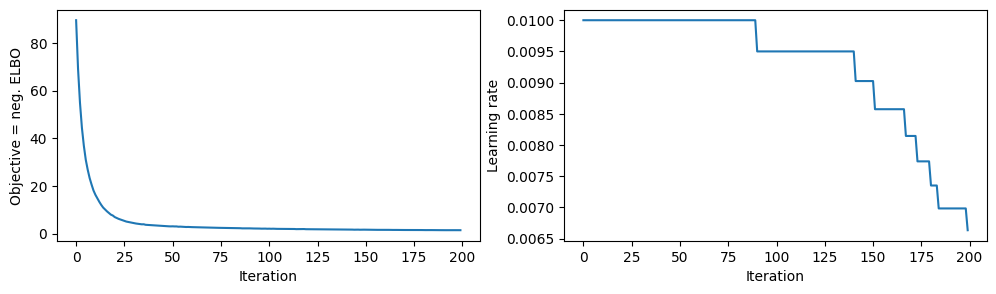

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(history.history["loss"])
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Objective = neg. ELBO")

ax2.plot(history.history["lr"])
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Learning rate")

More insightful, however, are the TensorBoard logs. They contain the objective and hyperparameters over the course of optimisation. This can be very handy to find out why things work or don't :D. The logs can be viewed in TensorBoard by running in the command line
```
$ tensorboard --logdir logs
```

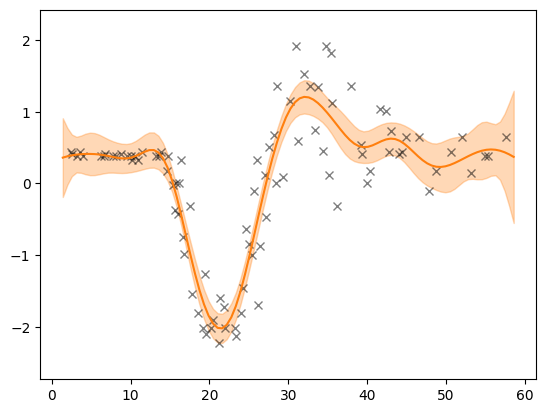

In [6]:
def plot(model, X, Y, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    x_margin = 1.0
    N_test = 100
    X_test = np.linspace(X.min() - x_margin, X.max() + x_margin, N_test).reshape(-1, 1)
    out = model(X_test)

    mu = out.f_mean.numpy().squeeze()
    var = out.f_var.numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mu - 2 * np.sqrt(var)
    upper = mu + 2 * np.sqrt(var)

    ax.set_ylim(Y.min() - 0.5, Y.max() + 0.5)
    ax.plot(X, Y, "kx", alpha=0.5)
    ax.plot(X_test, mu, "C1")

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)


prediction_model = deep_gp.as_prediction_model()
plot(prediction_model, X, Y)

## Post-training: saving, loading, and serving the model

We can store the weights and reload them afterwards.

In [7]:
prediction_model.save_weights("weights")

In [8]:
prediction_model_new = build_constant_input_dim_deep_gp(
    X, num_layers=2, config=config
).as_prediction_model()
prediction_model_new.load_weights("weights")

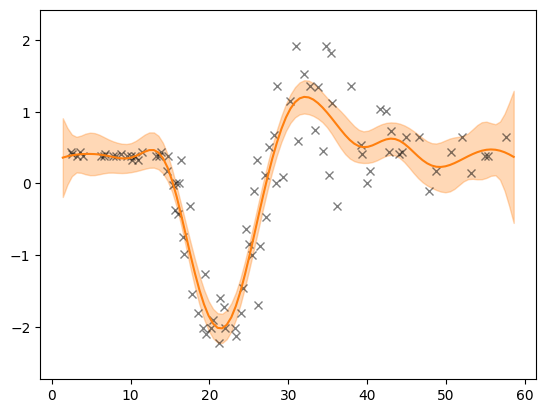

In [9]:
plot(prediction_model_new, X, Y)

Indeed, this prediction corresponds to the one of the original model.